# Pairs Trading

First, the imports

In [1]:
from itertools import combinations, permutations
from typing import Union, Literal

import numpy as np
import pandas as pd
import datetime
import yfinance
import matplotlib.pyplot as plt
from scipy.stats import norm

from statsmodels.tools import add_constant
from numpy_ext import rolling_apply

# To be deleted
from statsmodels.regression.linear_model import OLS as sm_OLS

## Implementaion of Tools
Then, the implementation of the OLS estimation, the main tool that almost all statistical estimates rely on throughout the code.

In [2]:

def OLS_estimation(y: pd.DataFrame, z: pd.DataFrame) -> dict:
    """
    OLS Estimation in the matrix form, i.e., the function assumes that the multiple regression equation (n_y) is estimated on the variables contained in z.
    The function also assumes both y and x to comes in the typical pd.DataFrame time series format.
    The index of DataFrame should represent time (observations), while each variable is contained in column.
    @param y: A DataFrame containing the dependent variables.
    @param z: A DataFrame containing the independent variables.
    @return: A dictionary containing the information from regression (Coefficients and thier statistics, residuals, etc.)
    """

    # Transposing the inputs to row-major format.
    _z = z.values.T
    _y = y.values.T
    # Number of y, z variables
    _n_z = _z.shape[0]
    _n_y = _y.shape[0]
    # Number of observations
    _n = _y.shape[1]

    # Estimating coefficients
    _zz_trans_inv = np.linalg.pinv(_z.dot(_z.T))  # Using pinv here to prevent singular matrix, which can occur in rolling estimates.
    _coefs = _y.dot(_z.T).dot(_zz_trans_inv)
    _df_coefs = pd.DataFrame(index=y.columns, columns=z.columns, dtype=float, data=_coefs)

    # Computing standard error of the coefficients
    _resid = _y - _coefs.dot(_z)
    _resid_cov = _resid.dot(_resid.T) / (_resid.shape[1] - _n_z)
    _coefs_se = np.sqrt(np.kron(_zz_trans_inv, _resid_cov).diagonal()).reshape(_n_z, _n_y).T
    _df_coefs_se = pd.DataFrame(index=y.columns, columns=z.columns, dtype=float, data=_coefs_se)

    # t-Stats
    _t_stats = _df_coefs / _coefs_se

    # p-values
    _p_values = pd.DataFrame(index=_t_stats.index, columns=_t_stats.columns, data=2 * norm.sf(np.abs(_t_stats)), dtype=float)

    # Saving other informations
    aic = np.linalg.det(_resid_cov) + 2 * (_n_z * _n_y) / _n
    bic = np.linalg.det(_resid_cov) + np.log(_n) * (_n_z * _n_y) / _n
    return {'results': pd.concat([_df_coefs, _df_coefs_se, _t_stats, _p_values], keys=['coefficient', 'std. error', 't-stats', 'p-values'], axis=1).stack(),
            'resid': _resid,
            'aic': aic,
            'bic': bic}


def produce_lags(z: Union[pd.DataFrame, pd.Series], lags: int = 1) -> pd.DataFrame:
    """
    Generates a DataFrame with lags as speficied in the lags variables.
    @param z: An input as either DataFrame or a Series with the data to be produced as lags.
    @param lags: Number of maximum lags, e.g., 3 means lag 1, 2, 3 will be produced.
    @return: A new DataFrame with identical index with z, but with pd.MultiIndex with first level = lag (1-index), second level = variable name.
    """
    if isinstance(z, pd.Series):
        z = z.to_frame()
    _z = pd.DataFrame(index=z.index, columns=pd.MultiIndex.from_product([range(1, lags+1), z.columns]), dtype=float)
    for l in range(1, lags+1):
        _z.loc[:, (l, slice(None))] = z.shift(l).values
    return _z

In [3]:
STATS_COLUMNS = ["Loading", "ADF stats", 'ECM1-p', 'ECM2-p', 'Reversion Mean', 'Reversion Speed', 'Reversion SD', 'Intercept']
MAX_LAGS = 10

def compute_stats(sr_price_a: pd.Series,
                  sr_price_b: pd.Series,
                  intercept: Union[float, np.ndarray, pd.Series] = None,
                  loading: Union[float, np.ndarray, pd.Series] = None,
                  adf_lags: Union[int, Literal['AIC', 'BIC']] = 1):
    """
    Performs and calculates the following statistics and routines in order:
    - Loading factor beta in the regression of P_A on P_B from OLS estimation
    - Engle-Granger Routine: Regress P_A on P_B to extract residuals, then perform stationary test on the residuals with Augmented Dickey-Fuller test (order=1)
    - OLS of the residual on 1-lag of itself for Ornstein–Uhlenbeck process parameters extractions.
    - Three parameters in the OU process: Reversion Mean, Reversion Speed, and Reversion SD.
    The function only computes the statistical parameters. Other tasks related to trading should be done outside.
    It is possible that if the given input is has a strong trend, then mean-reversion parameters would be invalid.
    @param sr_price_a: Price of the asset A
    @param sr_price_b: Price of the asset B
    @param adf_lags: Number of lags in the Augmented Dickey-Fuller. 'AIC', 'BIC' are allowed for optimization under info criteria.
    @param intercept: Intercept in the P_A on P_B regression, which can be fixed as a constant if input is float, or vary over time of an array is given. Reestimating otherwise.
    @param loading: Loading in the P_A on P_B regression. The input follows the same convention as intercept
    @return: A list of statistics. The name of each statistics is recorded above on STATS_COLUMNS variable as a list of string.
    """
    df_price_a = sr_price_a.to_frame()
    df_price_b = sr_price_b.to_frame()

    # First, find the loadings if not given
    if loading is None or intercept is None:
        dict_pair = OLS_estimation(df_price_a, add_constant(df_price_b))
        intercept = dict_pair['results'].iloc[0, 0]
        loading = dict_pair['results'].iloc[1, 0]
        resid = pd.Series(index=df_price_a.index, data=dict_pair['resid'].squeeze())
    else:  # Otherwise, assumed to be a constant or an array, apply accordingly.`
        price_a_predicted = intercept + loading * sr_price_b
        resid = sr_price_a - price_a_predicted

    # Next, stationary test
    # Preparing y data: delta of residuals
    resid_diff = resid.diff().rename('delta_resid')
    adf_y: pd.DataFrame = resid_diff.to_frame()

    # Preparing z data: Lag 1 residual, regardless of ADF order.
    df_adf_resid_lags = produce_lags(resid, 1)  # Always lag 1
    if isinstance(adf_lags, int):
        df_adf_delta_resid_lags = produce_lags(resid_diff, adf_lags)  # Only one lag
        adf_z = pd.concat([df_adf_resid_lags, df_adf_delta_resid_lags], axis=1)
        _adf_notna_idx = pd.concat([adf_y, adf_z], axis=1).notna().all(axis=1)
        dict_adf_results = OLS_estimation(adf_y.loc[_adf_notna_idx], add_constant(adf_z.loc[_adf_notna_idx]))
        df_adf = dict_adf_results['results']
        adf_statistics = df_adf.iloc[1]
    else:
        raise NotImplemented("autolag not implemnted")

    # Then ECM
    ecm_p_a_y = df_price_a.diff()
    ecm_p_a_z = pd.concat([sr_price_b.diff(), resid], axis=1)
    ecm_p_b_y = df_price_b.diff()
    ecm_p_b_z = pd.concat([sr_price_a.diff(), resid], axis=1)
    ecm_nonna_idx = pd.concat([ecm_p_b_y, ecm_p_b_z], axis=1).dropna().index
    dict_ecm_results_p_a = OLS_estimation(ecm_p_a_y.loc[ecm_nonna_idx], ecm_p_a_z.loc[ecm_nonna_idx])
    dict_ecm_results_p_b = OLS_estimation(ecm_p_b_y.loc[ecm_nonna_idx], ecm_p_b_z.loc[ecm_nonna_idx])
    ecm_p_a_resid_p_value = dict_ecm_results_p_a['results'].iloc[-1, -1]
    ecm_p_b_resid_p_value = dict_ecm_results_p_b['results'].iloc[-1, -1]

    # Finally, OU fitting
    df_ou_y = resid.rename('resid').to_frame()[1:]
    # df_ou_z = pair_resid.shift(1).rename('resid_lag1').dropna().to_frame()
    df_ou_z = produce_lags(resid, 1).dropna()
    dict_ou_results = OLS_estimation(df_ou_y, add_constant(df_ou_z))

    tau = 1.0 / 252.0
    cee = dict_ou_results['results'].iloc[0, 0]
    bee = dict_ou_results['results'].iloc[1, 0].squeeze()
    reversion_mean = cee / (1.0 - bee)
    reversion_speed = -1 * np.log(bee) / tau
    df_ou_y_predicted = add_constant(df_ou_z).dot(df_ou_estimation['coefficient'].values)
    ou_resid = df_ou_y.squeeze() - df_ou_y_predicted
    reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))

    return [loading,  # Spread
            adf_statistics['t-stats'],  # Stationary: ADF
            ecm_p_a_resid_p_value, ecm_p_b_resid_p_value,  # Stationary: ECM
            reversion_mean, reversion_speed, reversion_sd,  # OU Process
            intercept]


# Analysis

## Downloading stock prices

In [4]:
from sklearn.model_selection import train_test_split

# From the file download from siamchart, we can quickly check what large cap stocks in SET50 are
df_set50_stats = pd.read_excel(r"SET50_stats.xlsx", header=1, index_col=0)
universe_raw = df_set50_stats.sort_values('MCap (M)', ascending=False).index.astype(str)
universe = list(map(str.upper, universe_raw))
universe.remove("SCB")  # SCB has under gone a special circumstances. Price can be errorneous

# We download all prices up to 2022
df_all_prices = yfinance.download([f'{s}.BK' for s in universe],
                                  start=datetime.date(2010, 1, 1),
                                  end=datetime.date(2022, 1, 1))
df_prices: pd.DataFrame = (df_all_prices
                           .dropna(how='all')
                           .dropna(how='any', thresh=int(0.80 * len(df_all_prices)), axis=1)
                           .dropna(how='any', axis=0))['Adj Close']  # Drop anything that has too short of a history
df_prices = df_prices.loc[:, (df_prices.iloc[-1, :] / df_prices.iloc[0, :]) < 10.0]
df_prices, df_prices_test = train_test_split(df_prices, test_size=0.5, train_size=0.5, shuffle=False)  # 50/50 Train test spit
df_returns = df_prices.pct_change()

print(f'Number of the stock in the final universe = {len(df_prices.columns)}')
df_prices

[*********************100%***********************]  49 of 49 completed
Number of the stock in the final universe = 31


,ADVANC.BK,BANPU.BK,BBL.BK,BDMS.BK,BEM.BK,BH.BK,BLA.BK,BTS.BK,CPALL.BK,CPF.BK,...,MINT.BK,PTT.BK,PTTEP.BK,PTTGC.BK,SCC.BK,TISCO.BK,TOP.BK,TRUE.BK,TTB.BK,TU.BK
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-21,73.147247,27.857267,96.767807,5.454080,1.038602,31.174377,25.094757,2.063674,18.364094,20.733145,...,7.160356,18.743092,94.428238,33.765820,194.847137,15.029222,34.246021,2.222731,0.879459,8.364465
2011-10-25,76.804611,28.527378,100.944817,5.454080,1.038602,31.376797,24.657055,2.063674,18.464994,21.269344,...,7.197455,19.601051,96.896965,38.768162,206.308792,15.635241,35.575966,2.238608,0.886330,8.524550
2011-10-26,76.499840,28.623100,99.900581,5.475138,1.038602,31.376797,24.073456,2.063674,18.162291,21.269344,...,7.234556,19.337063,96.588379,38.611847,210.354019,15.514038,35.908451,2.190978,0.872588,8.604596
2011-10-27,76.804611,29.388939,101.641022,5.706779,1.059375,31.376797,25.240650,2.099878,18.263193,21.448080,...,7.382957,20.195017,96.588379,40.175072,211.702454,16.362463,37.404633,2.286238,0.920683,8.604596
2011-10-28,76.195053,29.963310,103.381447,5.622546,1.059375,32.186516,24.657055,2.136083,18.666796,21.448080,...,7.420058,20.591003,100.600044,41.581978,212.376663,16.604874,38.900822,2.222731,0.927554,8.644616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-14,116.473953,15.440619,129.206726,19.939398,6.780266,163.286942,45.365349,6.739109,53.808773,24.077084,...,33.149052,25.984617,59.353020,45.442978,384.248657,35.095932,57.745640,6.430132,1.540215,17.353510
2016-11-15,116.872833,14.891966,128.793930,19.759760,6.917705,163.728241,45.583450,6.739109,53.586414,23.869524,...,33.149052,26.779255,61.243240,46.219780,381.086121,35.095932,58.149464,6.475736,1.540215,17.035099
2016-11-16,114.878403,14.735209,127.968315,19.759760,6.871891,162.845642,45.365349,6.739109,54.253471,23.869524,...,33.149052,26.779255,61.432262,46.996586,377.923584,35.259926,57.139919,6.703754,1.525115,16.955492


## Choosing pair
### VAR Model
Since we have the tools for matrix OLS, we can quickly perform Vector Autogressive

In [5]:
var_lags = 5
var_y = df_returns[var_lags:]
var_z = produce_lags(df_prices, var_lags)
var_z = add_constant(var_z.dropna(how='any'))
var_y = var_y.loc[var_z.index]
pd.concat([var_y, var_z], axis=1)

,ADVANC.BK,BANPU.BK,BBL.BK,BDMS.BK,BEM.BK,BH.BK,BLA.BK,BTS.BK,CPALL.BK,CPF.BK,...,"(5, MINT.BK)","(5, PTT.BK)","(5, PTTEP.BK)","(5, PTTGC.BK)","(5, SCC.BK)","(5, TISCO.BK)","(5, TOP.BK)","(5, TRUE.BK)","(5, TTB.BK)","(5, TU.BK)"
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-31,0.044000,0.003195,0.006734,0.011236,0.000000,0.000000,0.017752,0.000000,0.016216,0.008333,...,7.160356,18.743092,94.428238,33.765820,194.847137,15.029222,34.246021,2.222731,0.879459,8.364465
2011-11-01,0.003831,-0.041401,-0.040134,-0.003704,-0.019608,0.000000,0.000000,0.000000,-0.015958,-0.008264,...,7.197455,19.601051,96.896965,38.768162,206.308792,15.635241,35.575966,2.238608,0.886330,8.524550
2011-11-02,0.003817,0.000000,0.017422,0.000000,0.000000,0.012579,0.023256,0.033898,-0.010811,0.016667,...,7.234556,19.337063,96.588379,38.611847,210.354019,15.514038,35.908451,2.190978,0.872588,8.604596
2011-11-03,-0.007604,-0.019934,0.000000,0.000000,0.000000,0.000000,-0.005682,-0.016393,0.005464,-0.008197,...,7.382957,20.195017,96.588379,40.175072,211.702454,16.362463,37.404633,2.286238,0.920683,8.604596
2011-11-04,0.034483,-0.023729,0.006849,0.014870,0.020000,0.037267,0.017143,-0.016667,-0.016304,-0.024793,...,7.420058,20.591003,100.600044,41.581978,212.376663,16.604874,38.900822,2.222731,0.927554,8.644616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-14,-0.020134,-0.039024,-0.021875,-0.026316,-0.032680,-0.026316,-0.009524,-0.005882,-0.016260,-0.056910,...,34.332943,27.494423,62.755432,46.219780,396.898804,35.423927,59.562820,6.156510,1.570416,17.592321
2016-11-15,0.003425,-0.035533,-0.003195,-0.009009,0.020270,0.002703,0.004808,0.000000,-0.004132,-0.008621,...,35.280064,27.732822,62.566402,46.413979,396.898804,36.407928,59.562820,6.794962,1.585516,17.671923
2016-11-16,-0.017065,-0.010526,-0.006410,0.000000,-0.006623,-0.005391,-0.004785,0.000000,0.012448,0.000000,...,35.753620,27.414959,61.432262,46.025574,393.736328,35.751926,57.947559,6.931774,1.570416,17.512716


In [6]:
dict_var_results = OLS_estimation(var_y, var_z)
df_var_results = dict_var_results['results']
predicted_return = df_var_results['coefficient'].unstack().dot(var_z.T).T
df_residuals = var_y - predicted_return

sr_correlations = df_residuals.corr().stack()
print(f"AIC = {dict_var_results['aic']}, BIC = {dict_var_results['bic']}")
# print(sr_correlations.loc[combinations(var_y.columns, 2)].sort_values(ascending=False).head(10).to_latex())
sr_correlations.loc[combinations(var_y.columns, 2)].sort_values(ascending=False)

AIC = 7.812600969305331, BIC = 27.81775190944314


ADVANC.BK  INTUCH.BK    0.761671
PTT.BK     PTTEP.BK     0.683762
BBL.BK     KBANK.BK     0.658183
KBANK.BK   KTB.BK       0.619772
PTT.BK     PTTGC.BK     0.585273
                          ...   
BEM.BK     TU.BK        0.080677
ADVANC.BK  EGCO.BK      0.078910
BLA.BK     EGCO.BK      0.071019
BEM.BK     DTAC.BK      0.068746
DTAC.BK    EGCO.BK      0.065558
Length: 465, dtype: float64

It is not surprising at all to see the prime suspects in the SET exchanges amongst the pairs with top correlations
- INTUCH is the holding company that has roughly 40% of ADVANC shares.
- INTUCH, DTAC, ADVANC are the largest telecommunication providers in Thailand
- PTT, PTTEP, PTTGC are in the same conglomorates.
- BBL, KBANK, KTB are the large banking sector names.

## Estimations
Next, we choose INTUCH and ADVANC as an illustration of the cointegration and its trading analysis

In [7]:
p_a_stock = 'INTUCH.BK'
p_b_stock = 'ADVANC.BK'
p_a: pd.Series = df_prices[p_a_stock]
p_b: pd.Series = df_prices[p_b_stock]
df_p_a: pd.DataFrame = p_a.to_frame()
df_p_b: pd.DataFrame = p_b.to_frame()
pd.concat([df_p_a, df_p_b], axis=1)

,INTUCH.BK,ADVANC.BK
Date,,
2011-10-21,18.464605,73.147247
2011-10-25,18.736139,76.804611
2011-10-26,18.328836,76.499840
2011-10-27,18.328836,76.804611
2011-10-28,18.328836,76.195053
...,...,...
2016-11-14,39.909214,116.473953
2016-11-15,39.909214,116.872833
2016-11-16,39.519859,114.878403


Plot of the normalized return clearly show cointegration behaviour.

Text(0, 0.5, 'Stock Price (Normalized)')

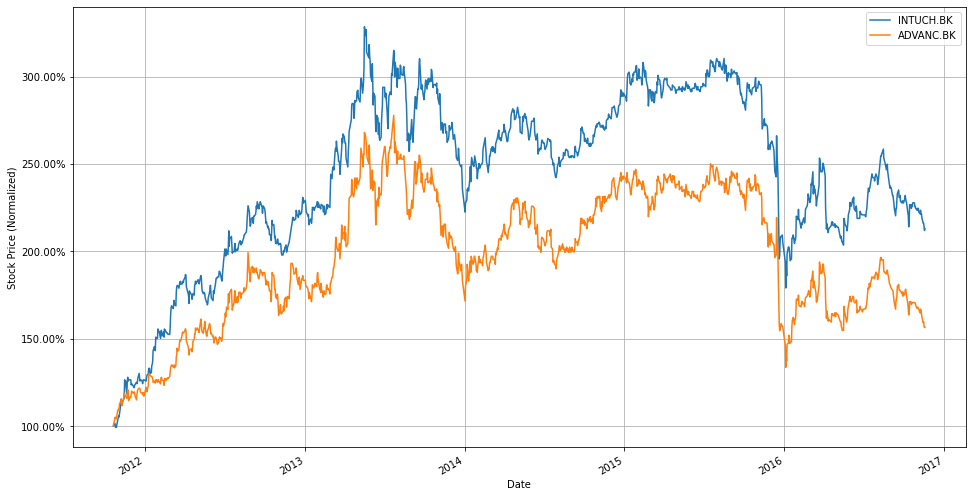

In [8]:
ax_coint_prices: plt.Axes = (p_a / p_a[0]).plot()
(p_b / p_b[0]).plot(ax=ax_coint_prices)
fig_coint_prices: plt.Figure = ax_coint_prices.get_figure()
fig_coint_prices.set_size_inches(16, 9)
ax_coint_prices.grid()
ax_coint_prices.legend()
ax_coint_prices.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda _y, _: f'{_y * 100:.2f}%'))
ax_coint_prices.set_ylabel("Stock Price (Normalized)")

We proceed with the first step in the Engle-Granger procedure by regressing the price of INTUCH on ADVANC

coefficient  std. error     t-stats  p-values
INTUCH.BK const        -0.359451    0.323184   -1.112221  0.266043
          ADVANC.BK     0.314864    0.002205  142.777571  0.000000

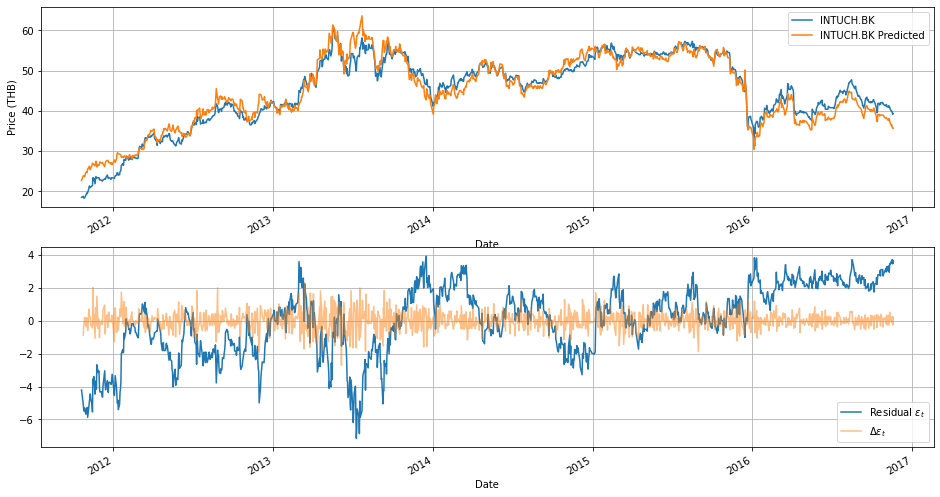

In [9]:
dict_pairs_results = OLS_estimation(df_p_a, add_constant(df_p_b))
df_pair_ols = dict_pairs_results['results']
p_a_predicted = add_constant(df_p_b).dot(df_pair_ols['coefficient'].values).rename(f"{p_a_stock} Predicted")
pair_resid = (p_a - p_a_predicted).rename('resid')

fig_pair: plt.Figure = plt.figure(figsize=(16, 9))
ax_p_a, ax_p_a_resid = fig_pair.subplots(2, 1)
p_a.plot(ax=ax_p_a)
p_a_predicted.plot(ax=ax_p_a)
ax_p_a.grid()
ax_p_a.set_ylabel('Price (THB)')
ax_p_a.legend()
pair_resid.plot(ax=ax_p_a_resid, label='Residual $\epsilon_t$')
pair_resid.diff().plot(ax=ax_p_a_resid, alpha=0.5, label='$\Delta \epsilon_t$')
ax_p_a_resid.grid()
ax_p_a_resid.legend()

# print(df_pair_ols.style.to_latex())
df_pair_ols

So, the equation relating two prices is

\begin{equation} P_{INTUCH, t} = -0.359452 + 0.314864 P_{ADVANC, t} + \epsilon_t \end{equation}

The value of predicted $\hat{P}_{INTUCH, t} \equiv -0.359452 + 0.314864 P_{ADVANC, t}$ is remarkably close to the real price. The residual $\epsilon_t$ is also range-bounded.

The stationarity of the residual is confirmed with the step 2 of Engle-Granger procedure by applying Augmented Dickey-Fuller on residuals.

In [10]:
adf_lags = 1
pair_resid_diff = pair_resid.diff().rename('delta_resid')
adf_y: pd.DataFrame = pair_resid_diff.to_frame()
df_adf_resid_lags = produce_lags(pair_resid, 1)  # Always lag 1
df_adf_delta_resid_lags = produce_lags(pair_resid_diff, adf_lags)
adf_z = pd.concat([df_adf_resid_lags, df_adf_delta_resid_lags], axis=1)
_adf_notna_idx = pd.concat([adf_y, adf_z], axis=1).notna().all(axis=1)
dict_adf_results = OLS_estimation(adf_y.loc[_adf_notna_idx], add_constant(adf_z.loc[_adf_notna_idx]))
# print(dict_adf_results['results'].to_latex())
dict_adf_results['results']

coefficient  std. error   t-stats      p-values
delta_resid const                0.008229    0.015520  0.530252  5.959374e-01
            (1, resid)          -0.029738    0.007402 -4.017347  5.885692e-05
            (1, delta_resid)    -0.192027    0.027840 -6.897492  5.292853e-12

The stationarity is confirmed by inspecting the **ADF-Statistics of the 1-lagged residual** $\epsilon_t$ against the critical value of the Augmented Dickey-Fuller test in McKinnon (2010). Here, we have the statistics -4.017344 compared to the critical value at 1% significant level with only a constant term in -3.45. This means that the null hypothesis $H_0: \beta = 0$ is rejected and there is no unit root, the residual is stationary and revert to mean.

In [11]:
from CVTables_Johansen import tableADF
adf_crits = pd.Series(index=[0.01, 0.05, 0.10, 0.90, 0.95, 1.00], data=tableADF(len(df_prices), 0), dtype=float)
adf_crits

0.01   -3.458300
0.05   -2.871040
0.10   -2.593690
0.90   -0.451613
0.95   -0.106025
1.00    0.536687
dtype: float64

Finally, we take the residual and construct the Error Correction Model for both asset prices to confirm that the residual coefficients are significant.

In [12]:
ecm_p_a_y = df_p_a.diff()
ecm_p_a_z = pd.concat([p_b.diff(), pair_resid], axis=1)
ecm_p_b_y = df_p_b.diff()
ecm_p_b_z = pd.concat([p_a.diff(), pair_resid], axis=1)
ecm_nonna_idx = pd.concat([ecm_p_b_y, ecm_p_b_z], axis=1).dropna().index
dict_ecm_results_p_a = OLS_estimation(ecm_p_a_y.loc[ecm_nonna_idx], ecm_p_a_z.loc[ecm_nonna_idx])
dict_ecm_results_p_b = OLS_estimation(ecm_p_b_y.loc[ecm_nonna_idx], ecm_p_b_z.loc[ecm_nonna_idx])
# print(pd.concat([dict_ecm_results_p_a['results'], dict_ecm_results_p_b['results']]).to_latex())
pd.concat([dict_ecm_results_p_a['results'], dict_ecm_results_p_b['results']])

coefficient  std. error    t-stats      p-values
INTUCH.BK ADVANC.BK     0.216717    0.004907  44.163338  0.000000e+00
          resid         0.016506    0.006566   2.513824  1.194301e-02
ADVANC.BK INTUCH.BK     2.820882    0.063874  44.163338  0.000000e+00
          resid        -0.119285    0.023507  -5.074441  3.886361e-07

Which both of the coefficients are significant.

## Ornstien-Uhnbleck Process

Next, we attempt to fit the (stationary) residual to the AR(1) process which the mean reverting properties are extracted from coefficients.

In [13]:
df_ou_y = pair_resid.rename('resid').to_frame()[1:]
# df_ou_z = pair_resid.shift(1).rename('resid_lag1').dropna().to_frame()
df_ou_z = produce_lags(pair_resid, 1).dropna()
dict_ou_results = OLS_estimation(df_ou_y, add_constant(df_ou_z))
df_ou_estimation = dict_ou_results['results']
# print(df_ou_estimation.to_latex())
df_ou_estimation

coefficient  std. error     t-stats  p-values
resid const          0.006213    0.015817    0.392808  0.694462
      (1, resid)     0.964361    0.007471  129.084798  0.000000

Reversion mean = 0.1743, Reversion Speed = 9.1451, Reversion SD = 4.6734


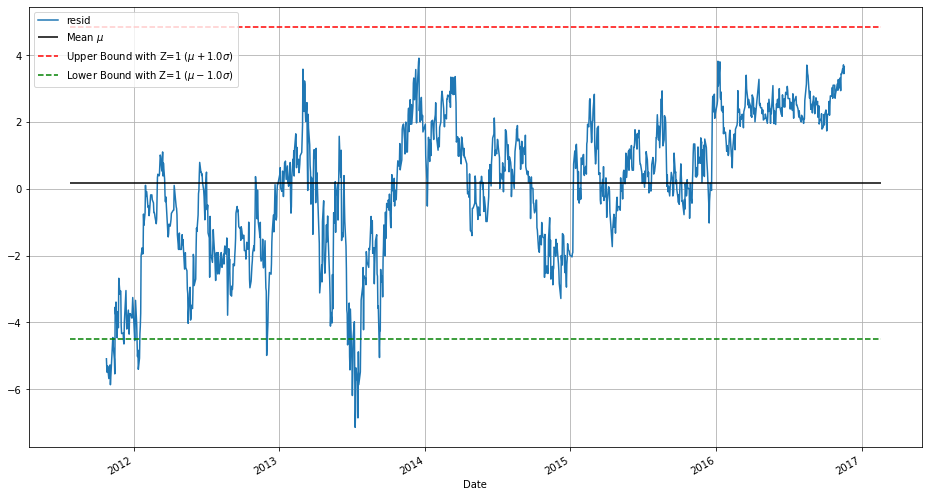

In [14]:
tau = 1.0 / 252.0
cee = df_ou_estimation.loc[('resid', 'const'), 'coefficient']
bee = df_ou_estimation.loc[('resid', (1, 'resid')), 'coefficient'].squeeze()
reversion_mean = cee / (1.0 - bee)
reversion_speed = -1 * np.log(bee) / tau

df_ou_y_predicted = add_constant(df_ou_z).dot(df_ou_estimation['coefficient'].values)
ou_resid = df_ou_y.squeeze() - df_ou_y_predicted
vol_eq = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
print(f"Reversion mean = {reversion_mean:.4f}, Reversion Speed = {reversion_speed:.4f}, Reversion SD = {vol_eq:.4f}")
ax_ou = df_ou_y.plot(figsize=(16, 9))
x_minmax = ax_ou.get_xlim()
ax_ou.hlines(reversion_mean, *x_minmax, label='Mean $\mu$', color='black')
ax_ou.hlines(reversion_mean + vol_eq, *x_minmax, label='Upper Bound with Z=1 ($\mu + 1.0\sigma)$', linestyle='--', color='red')
ax_ou.hlines(reversion_mean - vol_eq, *x_minmax, label='Lower Bound with Z=1 ($\mu - 1.0\sigma)$', linestyle='--', color='green')
ax_ou.grid()
ax_ou.legend()

The above routines are packaged in compute_stats() function to be further deployed to other stocks. We can confirm that the function yields the identical result to the recorded above using INTUCH, ADVANC as inputs.

In [15]:
pd.Series(data=compute_stats(df_prices['INTUCH.BK'], df_prices['ADVANC.BK']), index=STATS_COLUMNS).round(6)

Loading            0.314864
ADF stats         -4.017347
ECM1-p             0.011943
ECM2-p             0.000000
Reversion Mean     0.174336
Reversion Speed    9.145075
Reversion SD       4.673387
Intercept         -0.359451
dtype: float64

## Choosing Stock Revisited
We take the function, and then execute the routine on all of the combinations of the 31 stocks in the analysis universe.

In [16]:
df_market_stats = pd.DataFrame(index=pd.MultiIndex.from_tuples(permutations(df_prices.columns, 2)), columns=STATS_COLUMNS, dtype=float)
for s1, s2 in df_market_stats.index:
    print(f'Computing stats for {s1}, {s2}')
    stats = compute_stats(df_prices[s1], df_prices[s2])
    df_market_stats.loc[(s1, s2)] = stats
print(df_market_stats.sort_values('ADF stats')[['Loading', 'ADF stats']].head(10).to_latex())
df_market_stats.sort_values('ADF stats')

Computing stats for ADVANC.BK, BANPU.BK
Computing stats for ADVANC.BK, BBL.BK
Computing stats for ADVANC.BK, BDMS.BK
Computing stats for ADVANC.BK, BEM.BK
Computing stats for ADVANC.BK, BH.BK
Computing stats for ADVANC.BK, BLA.BK
Computing stats for ADVANC.BK, BTS.BK
Computing stats for ADVANC.BK, CPALL.BK
Computing stats for ADVANC.BK, CPF.BK
Computing stats for ADVANC.BK, CPN.BK
Computing stats for ADVANC.BK, DTAC.BK
Computing stats for ADVANC.BK, EGCO.BK
Computing stats for ADVANC.BK, GLOBAL.BK
Computing stats for ADVANC.BK, HMPRO.BK
Computing stats for ADVANC.BK, INTUCH.BK
Computing stats for ADVANC.BK, IRPC.BK
Computing stats for ADVANC.BK, IVL.BK
Computing stats for ADVANC.BK, KBANK.BK
Computing stats for ADVANC.BK, KTB.BK
Computing stats for ADVANC.BK, LH.BK
Computing stats for ADVANC.BK, MINT.BK
Computing stats for ADVANC.BK, PTT.BK
Computing stats for ADVANC.BK, PTTEP.BK
Computing stats for ADVANC.BK, PTTGC.BK
Computing stats for ADVANC.BK, SCC.BK
Computing stats for ADVANC.BK

/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))


Computing stats for BEM.BK, EGCO.BK
Computing stats for BEM.BK, GLOBAL.BK
Computing stats for BEM.BK, HMPRO.BK
Computing stats for BEM.BK, INTUCH.BK
Computing stats for BEM.BK, IRPC.BK
Computing stats for BEM.BK, IVL.BK
Computing stats for BEM.BK, KBANK.BK
Computing stats for BEM.BK, KTB.BK
Computing stats for BEM.BK, LH.BK
Computing stats for BEM.BK, MINT.BK
Computing stats for BEM.BK, PTT.BK
Computing stats for BEM.BK, PTTEP.BK
Computing stats for BEM.BK, PTTGC.BK
Computing stats for BEM.BK, SCC.BK
Computing stats for BEM.BK, TISCO.BK
Computing stats for BEM.BK, TOP.BK
Computing stats for BEM.BK, TRUE.BK
Computing stats for BEM.BK, TTB.BK
Computing stats for BEM.BK, TU.BK
Computing stats for BH.BK, ADVANC.BK
Computing stats for BH.BK, BANPU.BK
Computing stats for BH.BK, BBL.BK
Computing stats for BH.BK, BDMS.BK
Computing stats for BH.BK, BEM.BK
Computing stats for BH.BK, BLA.BK
Computing stats for BH.BK, BTS.BK
Computing stats for BH.BK, CPALL.BK
Computing stats for BH.BK, CPF.BK


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))


Computing stats for BH.BK, CPN.BK
Computing stats for BH.BK, DTAC.BK
Computing stats for BH.BK, EGCO.BK
Computing stats for BH.BK, GLOBAL.BK
Computing stats for BH.BK, HMPRO.BK
Computing stats for BH.BK, INTUCH.BK
Computing stats for BH.BK, IRPC.BK
Computing stats for BH.BK, IVL.BK
Computing stats for BH.BK, KBANK.BK
Computing stats for BH.BK, KTB.BK
Computing stats for BH.BK, LH.BK
Computing stats for BH.BK, MINT.BK
Computing stats for BH.BK, PTT.BK
Computing stats for BH.BK, PTTEP.BK
Computing stats for BH.BK, PTTGC.BK
Computing stats for BH.BK, SCC.BK
Computing stats for BH.BK, TISCO.BK
Computing stats for BH.BK, TOP.BK
Computing stats for BH.BK, TRUE.BK
Computing stats for BH.BK, TTB.BK
Computing stats for BH.BK, TU.BK
Computing stats for BLA.BK, ADVANC.BK
Computing stats for BLA.BK, BANPU.BK
Computing stats for BLA.BK, BBL.BK
Computing stats for BLA.BK, BDMS.BK
Computing stats for BLA.BK, BEM.BK
Computing stats for BLA.BK, BH.BK
Computing stats for BLA.BK, BTS.BK
Computing stats f

/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/181715844.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_market_stats.sort_values('ADF stats')[['Loading', 'ADF stats']].head(10).to_latex())


Loading  ADF stats    ECM1-p    ECM2-p  Reversion Mean  \
IRPC.BK  DTAC.BK    -0.021084  -4.343662  0.009817  0.103730        0.030758   
MINT.BK  BDMS.BK     1.862232  -4.339429  0.000030  0.000715       -0.032518   
KBANK.BK KTB.BK     10.534762  -4.334073  0.000257  0.000128        0.175720   
BDMS.BK  MINT.BK     0.505820  -4.276583  0.000708  0.000033        0.036654   
KTB.BK   KBANK.BK    0.081535  -4.197981  0.000071  0.000441        0.004651   
...                       ...        ...       ...       ...             ...   
BEM.BK   BBL.BK      0.018417   0.143825  0.058008  0.123097      -17.166042   
         TRUE.BK     0.364866   0.257162  0.015249  0.059708      -15.582095   
         TTB.BK      2.635861   0.311672  0.027326  0.019519      -30.397852   
         ADVANC.BK   0.011524   0.355130  0.036412  0.117848       -8.304726   
         INTUCH.BK   0.061382   0.410319  0.024952  0.092518       -5.119992   

                    Reversion Speed  Reversion SD  Intercept  
IRPC.BK  DTAC.BK           7.257593      0.637993   4.096204  
MINT.BK  BDMS.BK           8.697716      4.698956  -2.615506  
KBANK.BK KTB.BK            7.294095     20.290179  17.954161  
BDMS.BK  MINT.BK           8.489003      2.456525   2.133667  
KTB.BK   KBANK.BK          7.142916      1.801038   0.309329  
...                             ...           ...        ...  
BEM.BK   BBL.BK           -0.061348           NaN   0.668287  
         TRUE.BK          -0.054942           NaN   0.761057  
         TTB.BK           -0.027272           NaN  -1.207115  
         ADVANC.BK        -0.129777           NaN   1.536584  
         INTUCH.BK        -0.178655           NaN   0.435093  

[930 rows x 8 columns]

# Trading

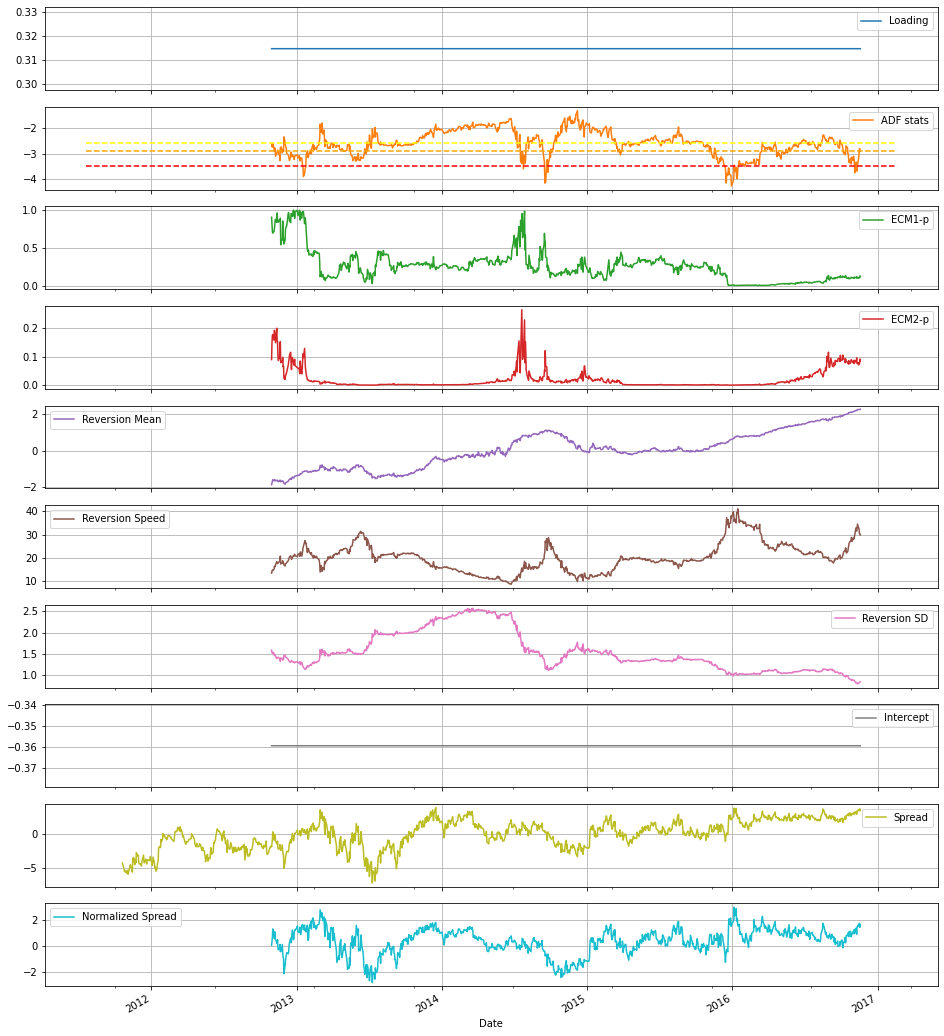

In [17]:
p_a_stock, p_b_stock = 'INTUCH.BK', 'ADVANC.BK'
dict_pairs_results = OLS_estimation(df_prices[p_a_stock].to_frame(), add_constant(df_prices[p_b_stock]))
intcpt = dict_pairs_results['results'].iloc[0, 0]
loading = dict_pairs_results['results'].iloc[1, 0]
df_stats = pd.DataFrame(index=df_prices.index, columns=STATS_COLUMNS,
                        data=rolling_apply(compute_stats, 252, df_prices[p_a_stock], df_prices[p_b_stock],
                                           intercept=intcpt, loading=loading))

df_stats['Spread'] = df_prices[p_a_stock] - loading * df_prices[p_b_stock] - intcpt
df_stats['Normalized Spread'] = (df_stats['Spread'] - df_stats['Reversion Mean']) / df_stats['Reversion SD']
bunch_of_axes = df_stats.plot(subplots=True)
bunch_of_axes[0].get_figure().set_size_inches(16, 20)

x_minmax = bunch_of_axes[1].get_xlim()
bunch_of_axes[1].hlines(adf_crits[0.01], *x_minmax, color='red', linestyles='--')
bunch_of_axes[1].hlines(adf_crits[0.05], *x_minmax, color='orange', linestyles='--')
bunch_of_axes[1].hlines(adf_crits[0.10], *x_minmax, color='yellow', linestyles='--')

for ax in bunch_of_axes:
    ax.grid()
    ax.legend()

In [18]:
# z_levels = [0.7, 1.0, 1.3]
z_levels = [1.0]
z_exit = +0.05
for z in z_levels:
    df_stats['Entry Signal'] = df_stats['Normalized Spread'].abs() > z
    df_stats['Spread Position'] = 0.0
    prev_spread_position = prev_spread_side = 0.0
    current_spread_position = 0.0
    cash = 100.0

    for d_i, sr_i in df_stats[1:].iterrows():
        entry_signal_i = sr_i['Entry Signal']
        normalized_spread_i = sr_i['Normalized Spread']
        spread_i = sr_i['Spread']

        if abs(prev_spread_position) < 1e-6 and entry_signal_i:
            current_spread_position = -1 * np.sign(normalized_spread_i)
            cash += -1 * current_spread_position * spread_i  # Opens position
        elif abs(prev_spread_position) >= 1e-6 and prev_spread_side * (normalized_spread_i - z_exit) > 0.0:
            cash += +1 * current_spread_position * spread_i # Covering
            current_spread_position = 0.0
        else:
            current_spread_position = prev_spread_position

        df_stats.loc[d_i, 'Spread Position'] = current_spread_position
        df_stats.loc[d_i, 'cash'] = cash
        prev_spread_position = current_spread_position
        prev_spread_side = np.sign(current_spread_position)
    df_stats['Mark-to-Market'] = df_stats['Spread Position'] * df_stats['Spread'] + df_stats['cash']
df_stats

,Loading,ADF stats,ECM1-p,ECM2-p,Reversion Mean,Reversion Speed,Reversion SD,Intercept,Spread,Normalized Spread,Entry Signal,Spread Position,cash,Mark-to-Market
Date,,,,,,,,,,,,,,
2011-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.207401,NaN,False,0.0,NaN,NaN
2011-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.087440,NaN,False,0.0,100.000000,100.000000
2011-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.398781,NaN,False,0.0,100.000000,100.000000
2011-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.494743,NaN,False,0.0,100.000000,100.000000
2011-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.302815,NaN,False,0.0,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-14,0.314864,-3.176123,0.097833,0.071121,2.273296,32.677911,0.814285,-0.359451,3.595175,1.623363,True,-1.0,143.714496,140.119321
2016-11-15,0.314864,-2.982036,0.107882,0.079269,2.272316,32.212819,0.818018,-0.359451,3.469582,1.463617,True,-1.0,143.714496,140.244914
2016-11-16,0.314864,-2.793387,0.105197,0.075060,2.279489,30.401549,0.837357,-0.359451,3.708202,1.706218,True,-1.0,143.714496,140.006294


Start date,2011-10-21
End date,2016-11-18
Total months,59
,Backtest
Annual return,7.071%
Cumulative returns,40.075%
Annual volatility,5.502%
Sharpe ratio,1.27
Calmar ratio,1.68
Stability,0.93
Max drawdown,-4.212%


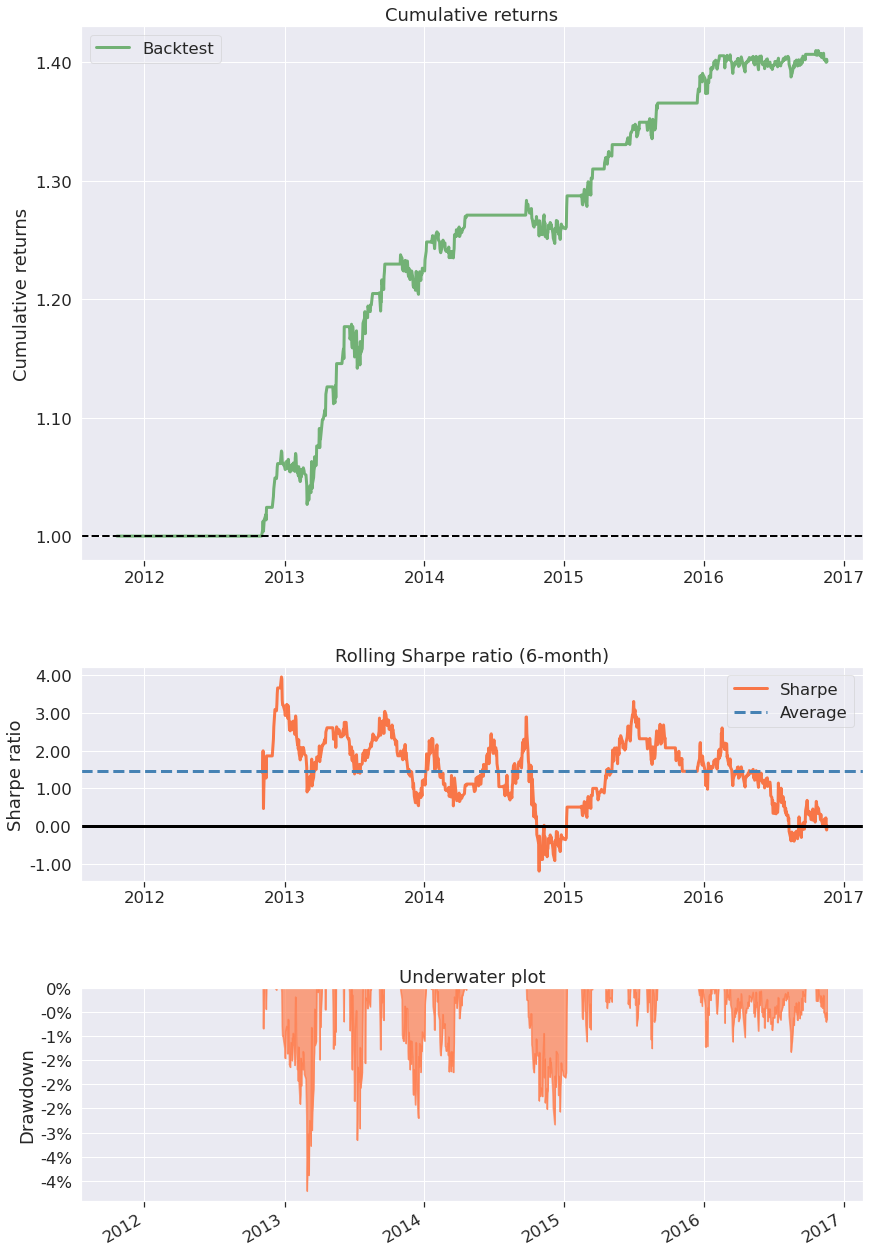

In [19]:
import pyfolio as pf
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pf.create_simple_tear_sheet(df_stats['Mark-to-Market'].pct_change().astype(float))

## Pairs Trading Code

In [20]:
def pairs_trading(stock_a: str,
                  stock_b: str,
                  rolling_estimation_days: int = 252,
                  entry_z: float = 1.0,
                  exit_z: float = 0.05,
                  initial_cash: float = 100.0,
                  loading_period: Union[int, Literal['rolling', None]] = None) -> pd.DataFrame:
    """
    Generates the pairs trading strategy (in and out of the sample) on the given names of stocks by pulling the price data from df_price and df_prices_test. Expected output is a data frame containing various trading statistics, most prominently the 'Mark-to-Market' column representing the trading agent's wealth on a given day resulting from execution of the outlined strategy.
    @param stock_a: Name of a stock A
    @param stock_b: Name of a stock B
    @param rolling_estimation_days: Number of data points which the rolling estimates will be computed.
    @param entry_z: Value of Z defining the entry point of pair trading strategy
    @param exit_z: Value of Z (tolerance) defining the exit point of pair trading strategy
    @param initial_cash: Cash at t=0
    @param loading_period: Parameters on the loading calculation. Float for fixed number, 'rolling' for re-estimated much like other mean-reversion parameters, or None to be re-estimated from the training set.
    @return: a DataFrame containing the trading statistics.
    """
    # Take the training set
    sr_p_a_train = df_prices[stock_a]
    sr_p_b_train = df_prices[stock_b]

    # Introducing the training set
    sr_p_a_test = df_prices_test[stock_a]
    sr_p_b_test = df_prices_test[stock_b]
    sr_p_a_ttl = pd.concat([sr_p_a_train, sr_p_a_test], axis=0, sort=True)
    sr_p_b_ttl = pd.concat([sr_p_b_train, sr_p_b_test], axis=0, sort=True)

    # Compute the loading
    if loading_period == 'rolling':  # Long-term estimation from the training set
        intcpt = loading = None
    elif isinstance(loading_period, int): # Fixed window
        sr_loadings = pd.Series(index=sr_p_a_ttl.index, dtype=float)
        sr_intercept = pd.Series(index=sr_p_b_ttl.index, dtype=float)
        for i in range(len(sr_loadings), 0, -loading_period):
            i_begin = max(0, i - loading_period)
            dict_loading_results = OLS_estimation(sr_p_a_ttl[i_begin:i].to_frame(),
                                                  add_constant(sr_p_b_ttl[i_begin:i].to_frame()))
            loading_i = dict_loading_results['results'].iloc[1, 0]
            intecept_i = dict_loading_results['results'].iloc[0, 0]
            sr_loadings[i_begin:i] = loading_i
            sr_intercept[i_begin:i] = intecept_i
        loading = sr_loadings
        intcpt = sr_intercept
    else:
        dict_pairs_results = OLS_estimation(sr_p_a_train.to_frame(), add_constant(sr_p_b_train.to_frame()))
        intcpt = dict_pairs_results['results'].iloc[0, 0]
        loading = dict_pairs_results['results'].iloc[1, 0]

    if hasattr(loading, '__len__'):
        df = pd.DataFrame(index=sr_p_a_ttl.index, columns=STATS_COLUMNS,
                          data=rolling_apply(compute_stats, rolling_estimation_days, sr_p_a_ttl, sr_p_b_ttl, intcpt, loading))
    else:
        # Perform rolling estimation on total data
        df = pd.DataFrame(index=sr_p_a_ttl.index, columns=STATS_COLUMNS,
                          data=rolling_apply(compute_stats, rolling_estimation_days, sr_p_a_ttl, sr_p_b_ttl,
                                             intercept=intcpt, loading=loading))

    # Computing spread (asset price) and the normalized value
    loading = df['Loading']
    intcpt = df['Intercept']
    df['Spread'] = sr_p_a_ttl - loading * sr_p_b_ttl[~loading.isna()] - intcpt
    df['Normalized Spread'] = (df['Spread'] - df['Reversion Mean']) / df['Reversion SD']

    # Computing positions
    df['Entry Signal'] = df['Normalized Spread'].abs() > entry_z
    df['Spread Position'] = 0.0
    prev_spread_position = prev_spread_side = 0.0
    current_spread_position = 0.0
    cash = initial_cash
    for d_i, sr_i in df[1:].iterrows():
        entry_signal_i = sr_i['Entry Signal']
        normalized_spread_i = sr_i['Normalized Spread']
        spread_i = sr_i['Spread']

        if abs(prev_spread_position) < 1e-6 and entry_signal_i:
            current_spread_position = -1 * np.sign(normalized_spread_i)
            cash += -1 * current_spread_position * spread_i  # Opens position
        elif abs(prev_spread_position) >= 1e-6 and prev_spread_side * (normalized_spread_i - exit_z) > 0.0:
            cash += +1 * current_spread_position * spread_i # Covering
            current_spread_position = 0.0
        else:
            current_spread_position = prev_spread_position

        df.loc[d_i, 'Spread Position'] = current_spread_position
        df.loc[d_i, 'cash'] = cash
        prev_spread_position = current_spread_position
        prev_spread_side = np.sign(current_spread_position)
    df['Mark-to-Market'] = df['Spread Position'] * df['Spread'] + df['cash']
    return df
df_comprehensive_stats = pairs_trading(p_a_stock, p_b_stock)

/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

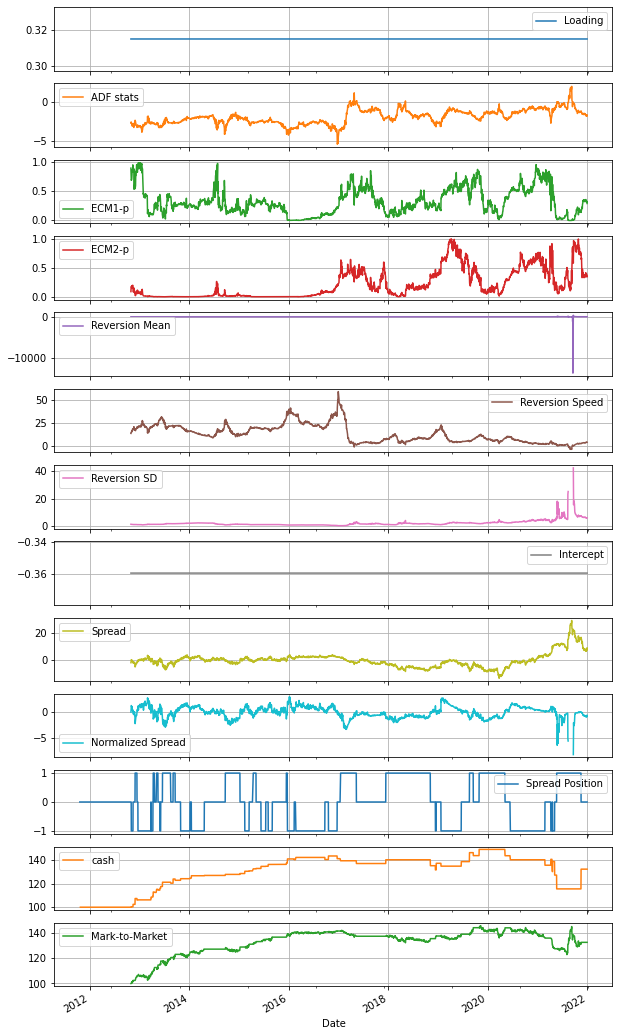

In [21]:
ax_stats = df_comprehensive_stats.plot(subplots=True, figsize=(10, 20))
for ax in ax_stats:
    ax.grid()
    ax.legend()

Start date,2012-10-31
End date,2021-12-30
Total months,106
,Backtest
Annual return,3.223%
Cumulative returns,32.472%
Annual volatility,6.417%
Sharpe ratio,0.53
Calmar ratio,0.21
Stability,0.42
Max drawdown,-15.671%


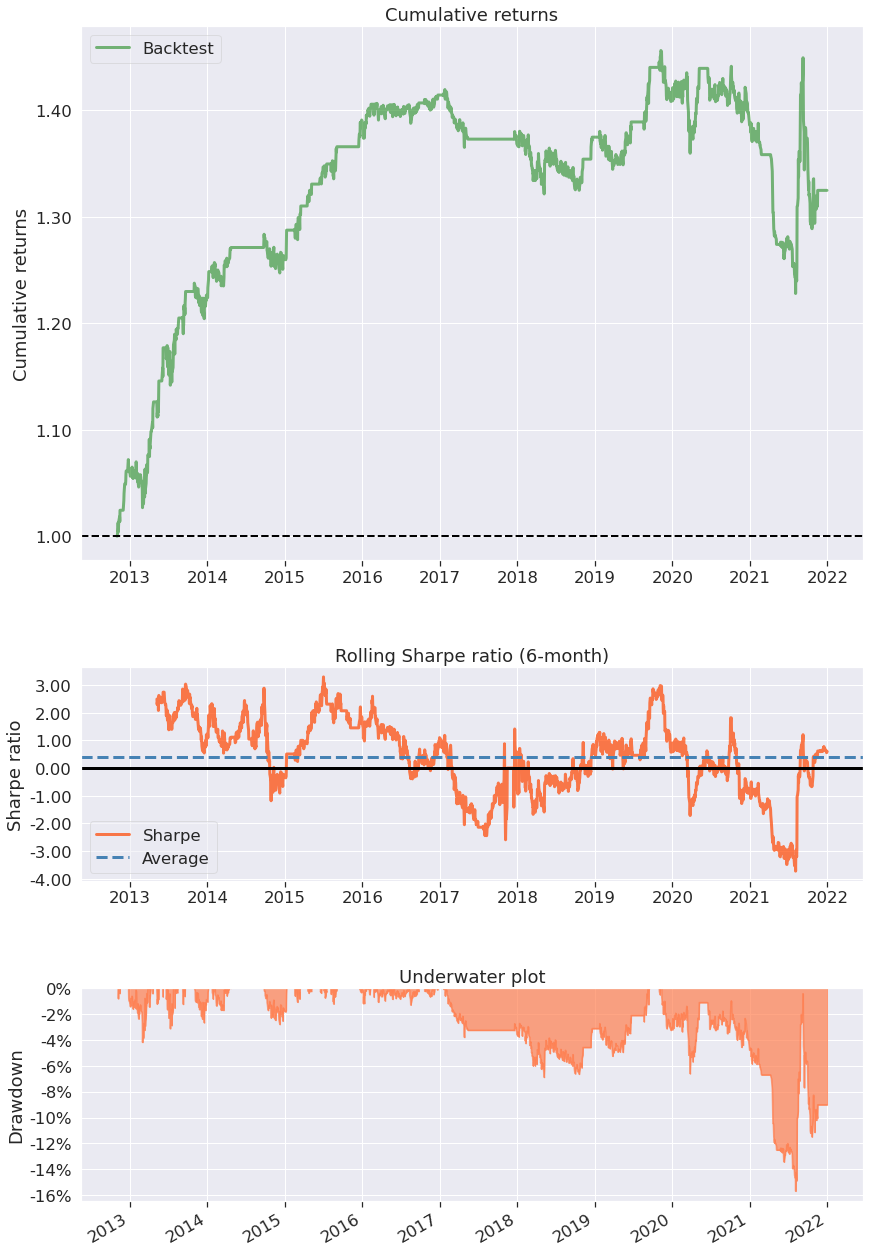

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sr_trading_returns = df_comprehensive_stats['Mark-to-Market'].pct_change().dropna()
    pf.create_simple_tear_sheet(sr_trading_returns)

In [23]:
varying_z = np.arange(0.7, 1.3, 0.1)
df_varying_z = pd.DataFrame(index=df_prices.index, columns=varying_z, dtype=float)
for z in varying_z:
    print(f'Computing entry Z = {z}')
    df_z = pairs_trading(p_a_stock, p_b_stock, entry_z=z)
    df_varying_z[z] = df_z['Mark-to-Market']

Computing entry Z = 0.7


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 0.7999999999999999


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 0.8999999999999999


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 0.9999999999999999


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 1.0999999999999999


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 1.1999999999999997


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

Computing entry Z = 1.2999999999999998


/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

In [24]:
# print(df_varying_z.iloc[-1, :].to_latex())
df_varying_z.iloc[-1, :]

0.7    140.429649
0.8    136.390558
0.9    139.666688
1.0    140.075387
1.1    142.503862
1.2    143.210574
1.3    137.885819
Name: 2016-11-18 00:00:00, dtype: float64

In [25]:
df_final_trades = pairs_trading(p_a_stock, p_b_stock, entry_z=1.2, loading_period='rolling')

/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/4237583596.py:78: RuntimeWarning: invalid value encountered in sqrt
  reversion_sd = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
/var/folders/mk/8krjc70d4fb6yfcfb45flslh0000gq/T/ipykernel_15421/423

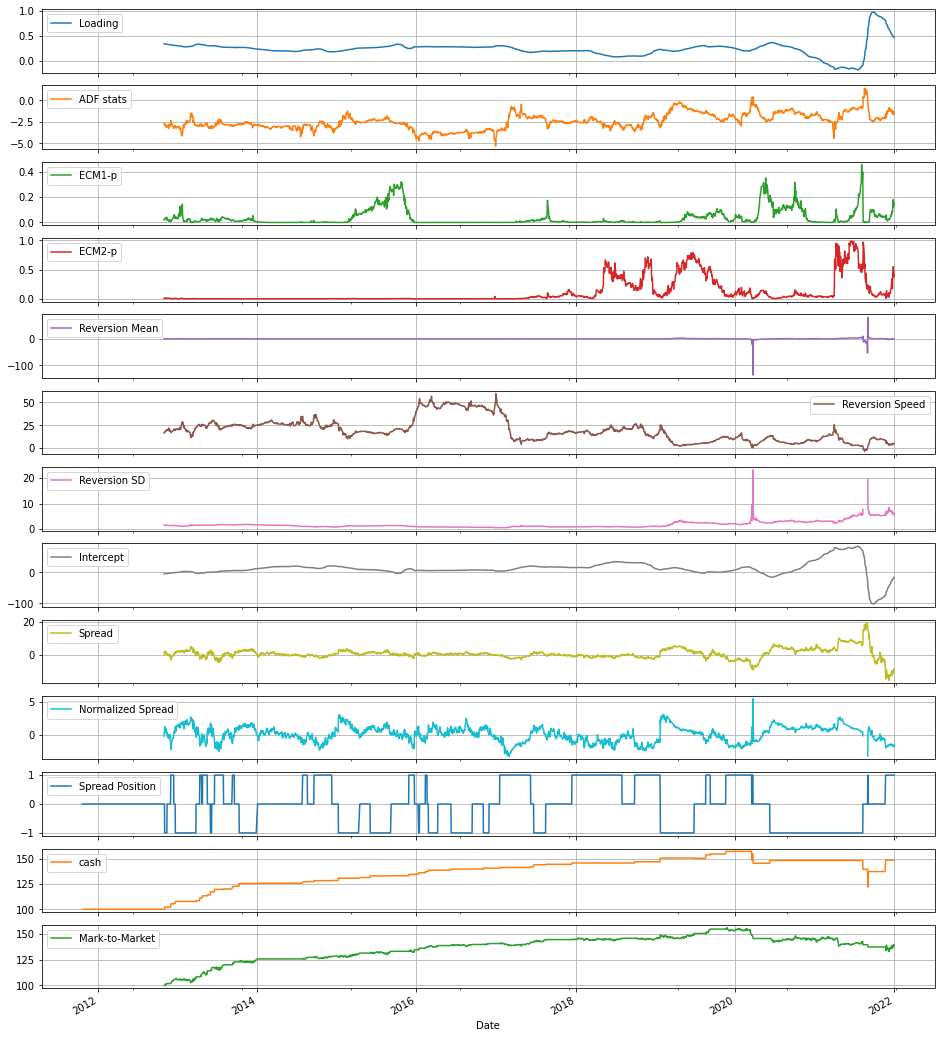

In [26]:
ax_final_stats = df_final_trades.plot(subplots=True, figsize=(16, 20))
for ax in ax_final_stats:
    ax.grid()
    ax.legend()

Start date,2012-10-31
End date,2021-12-30
Total months,106
,Backtest
Annual return,3.84%
Cumulative returns,39.662%
Annual volatility,5.558%
Sharpe ratio,0.71
Calmar ratio,0.26
Stability,0.66
Max drawdown,-14.839%


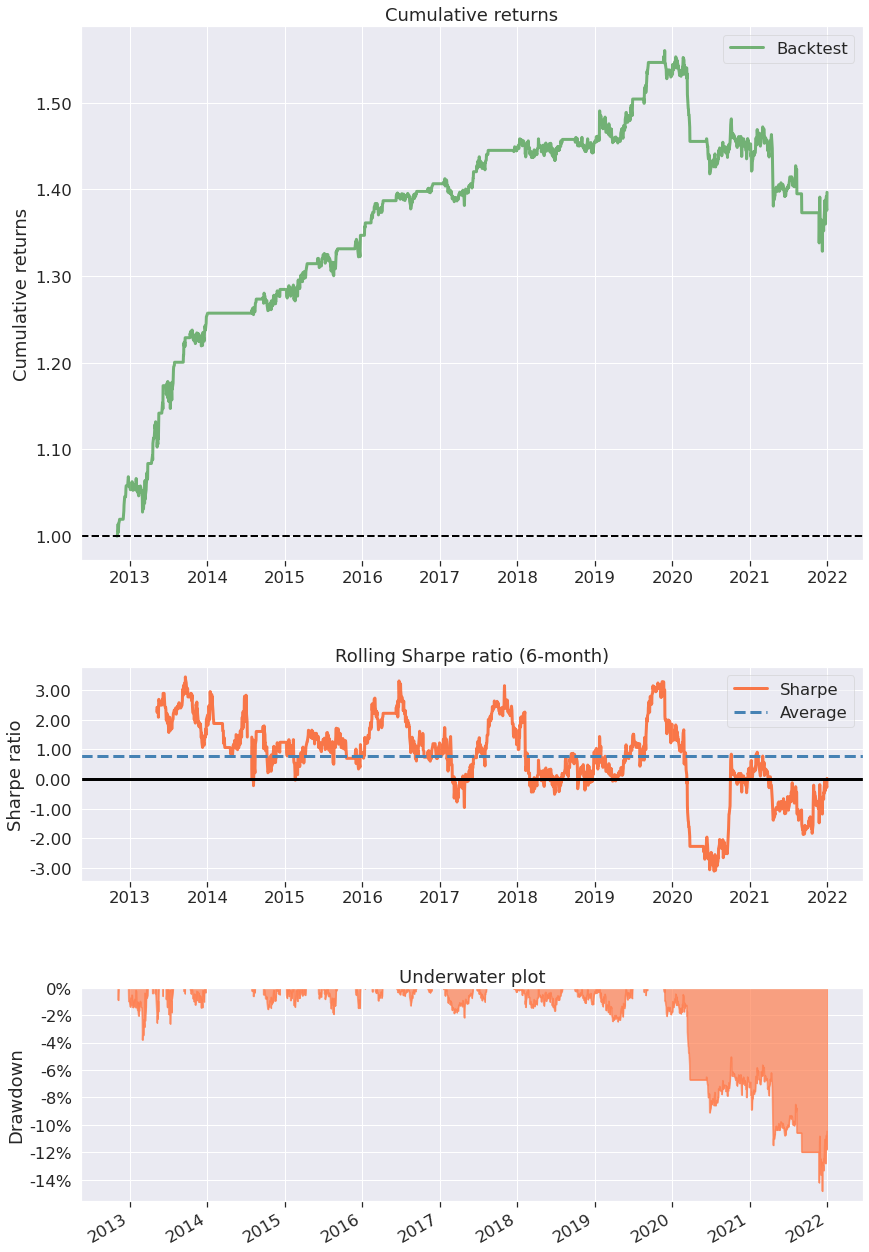

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sr_trading_returns = df_final_trades['Mark-to-Market'].pct_change().dropna()
    pf.create_simple_tear_sheet(sr_trading_returns)
